<a href="https://colab.research.google.com/github/saraadastan/sara/blob/master/SingleBunch_2mA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://gitlab.synchrotron-soleil.fr/PA/collective-effects/mbtrack2.git

Cloning into 'mbtrack2'...
remote: Enumerating objects: 1390, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 1390 (delta 20), reused 0 (delta 0), pack-reused 1340
Receiving objects: 100% (1390/1390), 661.75 KiB | 2.19 MiB/s, done.
Resolving deltas: 100% (949/949), done.


In [2]:
%cd mbtrack2

/content/mbtrack2


In [3]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.4 MB 39.5 MB/s 
     |████████████████████████████████| 1.6 MB 57.6 MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp37-cp37m-linux_x86_64.whl size=2185744 sha256=4153a5a5f01cc3a6d71ed1d69e81a9c1d0facc6c3ed5486bb5940e0e857daaaa
  Stored in directory: /root/.cache/pip/wheels/99/54/29/187b5768bbb7beeab6753bc30acf56f35bc8ca9c214a31e173
Successfully built mpi4py


In [4]:
import numpy as np
from mbtrack2.tracking import Synchrotron, Electron
from mbtrack2.utilities import Optics

In [5]:
#%%Elettra 2.0 parameters

h = 432 # Harmonic number of the accelerator.
L = 259.2 # Ring circumference in [m].
E0 = 2.4e9 # Nominal (total) energy of the ring in [eV].
particle = Electron() # Particle considered.
ac = 0.00013968121 # Momentum compaction factor.
U0 = 0.45021768 # Energy loss per turn in [eV].
tau = np.array([5.621e-3, 9.217e-3, 6.777e-3]) # Horizontal, vertical and longitudinal damping times in [s].
tune = np.array([32.27, 9.15]) # Horizontal and vertical tunes.
emit = np.array([2.2670e-10, 2.267e-12]) # Horizontal and vertical equilibrium emittance in [m.rad].
sigma_0 = 3.1152e-12 # Natural bunch length in [s].
sigma_delta = 1.9285e-3 # Equilibrium energy spread.
chro = [0.93, 2.43] # Horizontal and vertical (non-normalized) chromaticities.

local_beta = np.array([9.37, 2.004]) # Beta function at the tracking location.
local_alpha = np.array([0, 0]) # Alpha function at the tracking location.
local_dispersion = np.array([0, 0, 0, 0]) # Dispersion function and its derivative at the tracking location.
optics = Optics(local_beta=local_beta, local_alpha=local_alpha, 
                  local_dispersion=local_dispersion)

ring = Synchrotron(h=h, optics=optics, particle=particle, L=L, E0=E0, ac=ac, 
                   U0=U0, tau=tau, emit=emit, tune=tune, 
                   sigma_delta=sigma_delta, sigma_0=sigma_0, chro=chro)

In [6]:
from mbtrack2.tracking import Bunch

In [7]:
mybunch = Bunch(ring,  mp_number=1e5, current=2e-3)
mybunch.init_gaussian()

In [8]:
from mbtrack2.impedance import CircularResistiveWall
from mbtrack2.tracking import WakePotential

In [9]:
time = np.linspace(0, 30e-12, 10000) # Time points where the wake function will be evaluated in [s].
frequency = np.linspace(0.1e5, 100e9, 10000) # Frequency points where the impedance will be evaluated in [Hz].
length = ring.L # Beam pipe length in [m].
rho = 1.72e-8 # Effective resistivity to consider in [ohm.m] as in [1].
radius = 7.5e-3 # Beam pipe radius in [m].
exact = True # If False, approxmiated formulas are used for the wake function computations.

rw = CircularResistiveWall(time, frequency, length, rho, radius, exact)
rw.drop("Wydip")
rw.drop("Wxdip")
wp = WakePotential(ring, wakefield=rw, n_bin=60)

In [10]:
rw.wake_components

array(['Wlong'], dtype='<U5')

In [11]:
wp.track(mybunch)

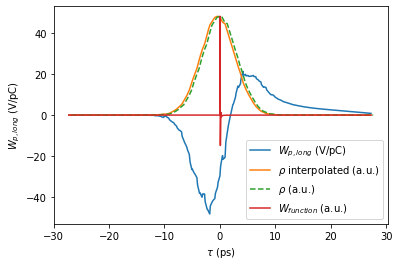

In [12]:
fig = wp.plot_last_wake("Wlong")

In [13]:
from mbtrack2.tracking import WakePotentialMonitor, BunchMonitor

In [14]:
wp_mon =  WakePotentialMonitor(bunch_number=0, wake_types=["Wlong"], n_bin=60, save_every=1, buffer_size=10, total_size=20000, file_name="track", mpi_mode=False)
bunchmonitor = BunchMonitor(bunch_number=0, total_size=20000, save_every=1, buffer_size=10, mpi_mode=False)

In [15]:
from mbtrack2.tracking import LongitudinalMap, RFCavity, SynchrotronRadiation

In [16]:
LongMap = LongitudinalMap(ring)
RF = RFCavity(ring, m=1, Vc=2e6, theta=np.arccos(ring.U0/2e6))
SR = SynchrotronRadiation(ring)

In [ ]:
turns = 20000
for i in range(turns):
  LongMap.track(mybunch)
  SR.track(mybunch)
  RF.track(mybunch)
  print(i)

  # collective effects part
  wp.track(mybunch)
  wp_mon.track(mybunch, wp)
  bunchmonitor.track(mybunch)
bunchmonitor.close()


In [18]:
from mbtrack2 import plot_wakedata, plot_bunchdata

In [19]:
import h5py as hp

In [20]:
file = hp.File("track.hdf5","r")

In [21]:
list(file)

['BunchData_0', 'WakePotentialData_0']

In [22]:
list(file["BunchData_0"])

['cs_invariant', 'current', 'emit', 'mean', 'std', 'time']

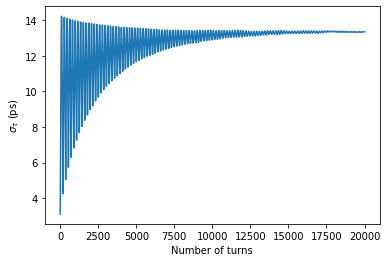

In [23]:
fig = plot_bunchdata(filenames="track.hdf5", bunch_number=0, dataset='std', dimension='tau', legend=None)
 

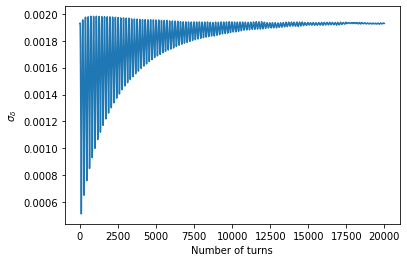

In [24]:
fig = plot_bunchdata(filenames="track.hdf5", bunch_number=0, dataset='std', dimension='delta', legend=None)

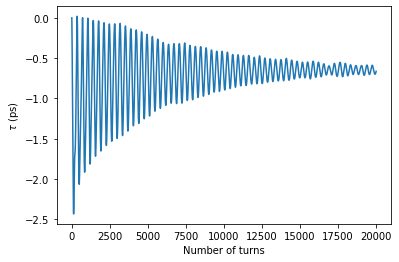

In [25]:
fig = plot_bunchdata(filenames="track.hdf5", bunch_number=0, dataset='mean', dimension='tau', legend=None)

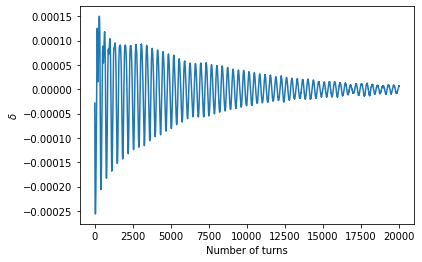

In [26]:
fig = plot_bunchdata(filenames="track.hdf5", bunch_number=0, dataset='mean', dimension='delta', legend=None)

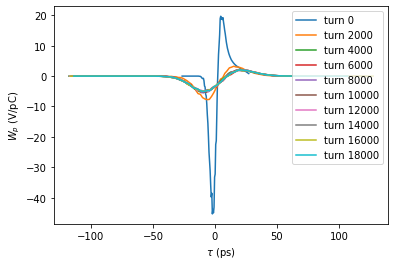

In [27]:
fig = plot_wakedata(filename="track.hdf5",bunch_number=0, wake_type="Wlong", start=0,
                     stop=None, step=2000, profile_plot=True, streak_plot=False,
                     bunch_profile=False, dipole=False)

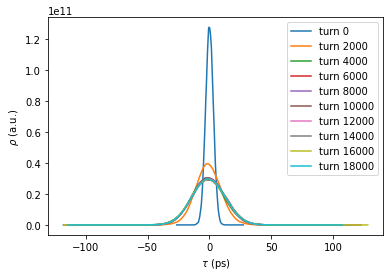

In [28]:
fig = plot_wakedata(filename="track.hdf5",bunch_number=0, wake_type="Wlong", start=0,
                     stop=None, step=2000, profile_plot=True, streak_plot=False,
                     bunch_profile=True, dipole=False)

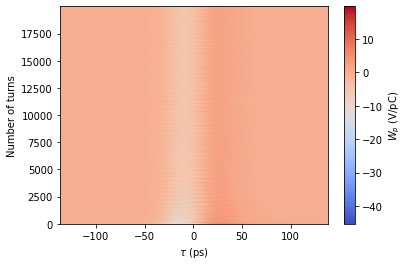

In [29]:
fig = plot_wakedata(filename="track.hdf5",bunch_number=0, wake_type="Wlong", start=0,
                     stop=None, step=None, profile_plot=False, streak_plot=True,
                     bunch_profile=False, dipole=False)

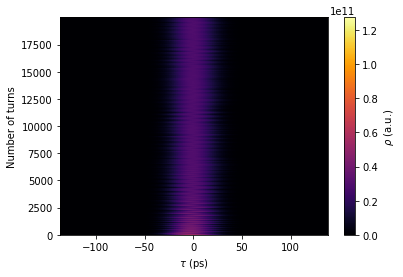

In [30]:
fig = plot_wakedata(filename="track.hdf5",bunch_number=0, wake_type="Wlong", start=0,
                     stop=None, step=None, profile_plot=False, streak_plot=True,
                     bunch_profile=True, dipole=False)

In [31]:
Bunchlength = 0;
Energyspread = 0;
counter = 0;
for i in range(20000):
  #print(i,np.array(file["BunchData_0"]["std"][4,i]),np.array(file["BunchData_0"]["std"][5,i]))
  #print(i,np.array(file["BunchData_0"]["std"][4,i]))
  Bunchlength = Bunchlength + np.array(file["BunchData_0"]["std"][4,i])
  Energyspread = Energyspread + np.array(file["BunchData_0"]["std"][5,i])
  counter = counter + 1
  #print (counter,Bunchlength/counter)


print (Bunchlength/counter)
print (Energyspread/counter)


1.2775062471499309e-11
0.001843186429375431
